### Problem setting
we consider a three stage multi-item news-vendor problem
1) First stage: agents require certain units of fix-investment from agents <br>
&emsp;variable:<br>
&emsp;&emsp; &emsp;$ x_1 $:vector - units of items to stock<br>
&emsp;coeffients:<br>
&emsp;&emsp; &emsp;$ c_1 $:vector - costs for stocking each unit<br>
            
2) Second stage: vendor buys news paper from agent, the available quantity range depends on the invesment <br>
&emsp;  variable:<br>
&emsp; &emsp; &emsp; $ x_2 $:vector - units of items to stock more<br>
&emsp; &emsp; &emsp; $ r_2 $:vector - remain quantity after retailing befor restocking<br>
&emsp; coeffients:<br>
&emsp; &emsp; &emsp; $ c_2 $:vector - costs for restocking <br>
&emsp; random variable:<br>
&emsp; &emsp; &emsp; $ d_2 $:vector - demands of items<br>
&emsp; &emsp; &emsp; $ p_2 $:vector - retail price of items

3) Third stage: vendor sells news paper to individuals<br>
&emsp;  random variables:<br>
&emsp; &emsp; &emsp; $ d_3 $:vector - demands of items <br>
&emsp; &emsp; &emsp; $ p_3 $:vector - retail price of items

#### Stage Scenario Data

In [203]:
# Let's say the problem

# with 5 items to stock and retail
n_item = 10

# with 4 scenario in second stage
S_scenario = 5
L_scenario = 5



import numpy as np
import numpy.random as random 
# budge at first 
b_1 = n_item*random.randint(low=5,high = 10)

# additional budget 
b_2 = n_item*random.randint(low=5,high = 10)


# costs
c_1 = random.randint(low=1,high = 10, size = n_item)
c_2 = random.randint(low=1,high = 10, size = n_item)



# price
p_2 = c_1 + random.randint(low=1,high = 10, size = n_item)
p_3 = c_1 + random.randint(low=1,high = 10, size = n_item)

# damands
d_2 = [random.randint(low=1,high = 10, size = n_item) for i in range(S_scenario)]
d_3_scenario_wrap = [[random.randint(low=1,high = 10, size = n_item) \
                          for j in range(L_scenario)]\
                                 for i in range(S_scenario)]
# Probabilities
d_2_prob = random.random_sample((S_scenario,))
d_2_prob = d_2_prob/np.sum(d_2_prob)
d_3_prob_wrap = [random.random_sample((L_scenario,)) for i in range(S_scenario) ]
d_3_prob_wrap = [ row/np.sum(row) for row in d_3_prob_wrap]

In [204]:
'''
Template of scenario data structure
:: dictionary
scenario['stage_n'] = {
    'dc_var':['x_1'],
    'rd_var':[],
    'cf':{'b_1':b_1,'c_1':c_1},
    'conditions':[],
    'conditions_val':[],
    'rd_prob':{}
}
'''

scenario = {'n_item':n_item,
            'S_scenario':S_scenario,
            'L_scenario':L_scenario
           }

scenario['stage_1'] = {
    'dc_var':['x_1'],
    'rd_var':[],
    'cf':{'b_1':b_1,'c_1':c_1},
    'condition':[],
    'conditions_val':[],
    'rd_prob':{}
}

scenario['stage_2'] = {
    'dc_var':['x_2','r_2'],
    'rd_var': ['d_2'],
    'cf':{'b_2':b_2,'c_2':c_2,'p_2':p_2},
    'condition': [],
    'conditions_val': [],
    'rd_prob':{
        0:(d_2,d_2_prob)
    }
}

scenario['stage_3'] = {
    'dc_var':[],
    'rd_var': ['d_3'],
    'cf':{'p_3':p_3},
    'condition': ['d_2'],
    'conditions_val': [d_2],
    'rd_prob':{
        i:(d_3_scenario_wrap[i],d_3_prob_wrap[i]) for i in range(len(d_3_scenario_wrap)) 
    }
}

In [205]:
scenario

{'n_item': 10,
 'S_scenario': 5,
 'L_scenario': 5,
 'stage_1': {'dc_var': ['x_1'],
  'rd_var': [],
  'cf': {'b_1': 70, 'c_1': array([9, 3, 4, 3, 6, 7, 9, 7, 2, 9])},
  'condition': [],
  'conditions_val': [],
  'rd_prob': {}},
 'stage_2': {'dc_var': ['x_2', 'r_2'],
  'rd_var': ['d_2'],
  'cf': {'b_2': 50,
   'c_2': array([8, 1, 3, 4, 2, 6, 1, 2, 7, 2]),
   'p_2': array([17,  5, 10,  4,  8, 14, 14, 14,  7, 17])},
  'condition': [],
  'conditions_val': [],
  'rd_prob': {0: ([array([8, 7, 5, 5, 9, 4, 1, 1, 6, 2]),
     array([5, 8, 9, 5, 8, 3, 2, 5, 1, 6]),
     array([2, 2, 2, 9, 8, 6, 2, 4, 8, 5]),
     array([4, 2, 1, 6, 1, 9, 6, 2, 7, 4]),
     array([6, 4, 3, 6, 1, 9, 3, 7, 6, 6])],
    array([0.30882478, 0.05231884, 0.0808614 , 0.24815023, 0.30984475]))}},
 'stage_3': {'dc_var': [],
  'rd_var': ['d_3'],
  'cf': {'p_3': array([17,  9,  9, 10,  9, 15, 12, 12, 10, 13])},
  'condition': ['d_2'],
  'conditions_val': [[array([8, 7, 5, 5, 9, 4, 1, 1, 6, 2]),
    array([5, 8, 9, 5, 8, 3, 2,

#### Benchmark of reward $Y$ for a given policy of $x_2$
Specifically,  $x_2(x_1, \xi^2_i)$<br>
$x_1$ is a real value vector and $x_2$ is function responding to scenarios and first decision<br>
No SSD contraints to consider

In [206]:
 ### policy example ###
def x_2_policy(x_1, s):
    return x_1

# a simple policy to order the same as previous 

In [207]:
import gurobipy as gp
from gurobipy import GRB
from collections import defaultdict
from gurobipy import quicksum as qsum

def three_stage_problem_no_SSD(scenario, return_solution=False):
    n_item = scenario['n_item']
    S_scenario = scenario['S_scenario']
    L_scenario = scenario['L_scenario']
    d_2 = scenario['stage_2']['rd_prob'][0][0]
    prob_of_d_2 =  scenario['stage_2']['rd_prob'][0][1]
    
    d_3 = {}
    for s in range(S_scenario):
        d_3[s] = {}
        for l in range(L_scenario):
            d_3[s][l] = scenario['stage_3']['rd_prob'][s][0][l]
    
    prob_of_d_3 = {}
    for s in range(S_scenario):
        prob_of_d_3[s] = {}
        for l in range(L_scenario):
            prob_of_d_3[s][l] = scenario['stage_3']['rd_prob'][s][1][l]
    
    c_1 = scenario['stage_1']['cf']['c_1']
    c_2 = scenario['stage_2']['cf']['c_2']
    p_2 = scenario['stage_2']['cf']['p_2']
    p_3 = scenario['stage_3']['cf']['p_3']
    
    m = gp.Model(f'main')
    m.Params.LogToConsole = 0
    x_1 = m.addVars(n_item, vtype = GRB.CONTINUOUS, name = 'x_1')
    x_2 = {}
    for s in range(S_scenario):
        x_2[s] = m.addVars(n_item, vtype = GRB.CONTINUOUS, name = f'x_2_s={s}')
    
    # retail quantatity 
    # gurobi itself provide genral constraint to handle max or min functions  
    # which introduces extra binary variables into the model
    s_2 = {}
    for i in range(S_scenario):
        s_2[i] = m.addVars(n_item, vtype = GRB.CONTINUOUS, name = f's_2_s={i}')
        for j in range(n_item):
            m.addConstr( s_2[i][j] == gp.min_(x_1[j], constant = d_2[i][j]))
    
    # budget constraint
    cost_1 = qsum(x_1[i]*c_1[i] for i in range(n_item))
    m.addConstr(cost_1<=scenario['stage_1']['cf']['b_1'], name='budget_constr_stage_1')
    
    tot_2_l = {}
    tot_2_r = {}
    for i in range(S_scenario):
        tot_2_r[i] = qsum(p_2[j]*s_2[i][j] for j in range(n_item))
        tot_2_l[i] = qsum(x_2[i][j]*c_2[j] for j in range(n_item))
        m.addConstr(tot_2_l[i]<=tot_2_r[i] + scenario['stage_2']['cf']['b_2'], \
                  name='budget_constr_stage_2')
        
    # revenue
    revenue_2_expected = qsum(tot_2_r[i]*prob_of_d_2[i] for i in range(S_scenario))
    cost_2_expected = qsum(tot_2_l[i]*prob_of_d_2[i] for i in range(S_scenario))
    
    revenue_3_conditional_expected = {}
    s_3 = {}
    for i in range(S_scenario):
        revenue_3 = {}
        excess_3 = {}
        s_3[i] = {}
        for l in range(L_scenario):
            revenue_3[l] = 0
            excess_3[l] = m.addVars(n_item, \
                                   vtype = GRB.CONTINUOUS, \
                                   name = f'excess_3_{i}_{l}')
            s_3[i][l] = m.addVars(n_item, \
                                   vtype = GRB.CONTINUOUS, \
                                   name = f's_3_{i}_{l}')
            for j in range(n_item):
                m.addConstr( excess_3[l][j] == x_2[i][j]+x_1[j]-s_2[i][j])
                m.addConstr( s_3[i][l][j] == gp.min_(excess_3[l][j],constant = d_3[i][l][j]))
                revenue_3[l] += p_3[j]*s_3[i][l][j]
        revenue_3_conditional_expected[i] = qsum(prob_of_d_3[i][l]*revenue_3[l]\
                                                 for l in range(L_scenario))
    revenue_3_expected = qsum(revenue_3_conditional_expected[i]*prob_of_d_2[i]\
                              for i in range(S_scenario))
    
    # since budget is constrained
    # maximize revenue is equal to maximize the profit
    obj = revenue_2_expected - cost_1 + revenue_3_expected-cost_2_expected
    m.setObjective(obj, GRB.MAXIMIZE)
    m.optimize()

   
    if return_solution:
        return [_.X for _ in x_1.values()], \
                [[_.X for _ in x_2[k].values() ] for k in range(S_scenario)]
    else:
        print(cost_1.getValue())
        print([tot_2_l[i].getValue() for i in range(S_scenario)])
        print([tot_2_r[i].getValue() for i in range(S_scenario)])
        for s in range(S_scenario):
            print(s, [sum(s_3[s][l][j].X*p_3[j] for j in range(n_item)) for l in range(L_scenario)])
        print(obj.getValue())
        return m

In [208]:
m = three_stage_problem_no_SSD(scenario)

70.0
[161.0, 144.88888888888889, 158.0, 170.0, 154.0]
[143.88888888888889, 94.88888888888889, 147.88888888888889, 130.88888888888889, 143.88888888888889]
0 [504.0, 565.0, 527.0, 690.0, 437.0]
1 [622.6666666666666, 618.0, 663.6666666666666, 538.6666666666666, 456.0]
2 [549.0, 449.0, 469.0, 529.0, 449.0]
3 [546.0, 558.0, 516.0, 495.0, 681.0]
4 [463.0, 523.0, 517.0, 562.0, 446.0]
444.15295504187714


In [209]:
def evaluation_policy(x_1, x_2, scenario):
    n_item = scenario['n_item']
    S_scenario = scenario['S_scenario']
    L_scenario = scenario['L_scenario']
    d_2 = scenario['stage_2']['rd_prob'][0][0]
    prob_of_d_2 =  scenario['stage_2']['rd_prob'][0][1]
    
    d_3 = {}
    for s in range(S_scenario):
        d_3[s] = scenario['stage_3']['rd_prob'][s][0]
    
    prob_of_d_3 = {}
    for s in range(S_scenario):
        prob_of_d_3[s] = scenario['stage_3']['rd_prob'][s][1]
    
    c_1 = scenario['stage_1']['cf']['c_1']
    c_2 = scenario['stage_2']['cf']['c_2']
    p_2 = scenario['stage_2']['cf']['p_2']
    p_3 = scenario['stage_3']['cf']['p_3']
    b_2 = scenario['stage_2']['cf']['b_2']
    
    rst = {}
    rst['stage_2'] = {}
    rst['stage_3'] = {}
    s_2 = {}
    
    for s in range(S_scenario):
        s_2[s] = [min(x_1[j], d_2[s][j]) for j in range(n_item)]
        rst['stage_3'][s] = {}
        for l in range(L_scenario):
            rst['stage_3'][s][l] = {
                'revenue': sum(p_3[j]*min(x_1[j]+x_2[s][j]-s_2[s][j], d_3[s][l][j])\
                               for j in range(n_item)),
                'cost':0,
                'z_3':sum(p_3[j]*min(x_1[j]+x_2[s][j]-s_2[s][j], d_3[s][l][j])\
                               for j in range(n_item)) - 0,
                'expected_reward': 0,
                'prob':prob_of_d_3[s][l]
            }
        
        rst['stage_2'][s]={
            'revenue': sum(p_2[j]*s_2[s][j] for j in range(n_item)),
            'cost':sum(c_2[j]*x_2[s][j] for j in range(n_item)),
            'z_2':sum(p_2[j]*s_2[s][j] for j in range(n_item)) - \
                    sum(c_2[j]*x_2[s][j] for j in range(n_item)),
            'expected_reward': sum( rst['stage_3'][s][l]['prob']*rst['stage_3'][s][l]['z_3']\
                                       for l in range(L_scenario)),
            'prob':prob_of_d_2[s]
        }
        
            
    rst['stage_1']={
        'revenue': 0,
        'z_1': - sum(c_1[j]*x_1[j] for j in range(n_item)),
        'cost':sum(c_1[j]*x_1[j] for j in range(n_item)),
        'expected_reward': sum( rst['stage_2'][s]['prob']*\
                               (rst['stage_2'][s]['z_2'] + rst['stage_2'][s]['expected_reward'])
                                       for s in range(S_scenario) ),
        'prob': 1.0
    }
    
    return rst

In [266]:
x_1_opt,x_2_opt = three_stage_problem_no_SSD(scenario, return_solution=True)

In [267]:
eval_rst = evaluation_policy(x_1_opt, x_2_opt, scenario)
expected = eval_rst['stage_1']['z_1'] + eval_rst['stage_1']['expected_reward']
print(expected)

444.1529550418768


#### Benchmark

In [212]:
def ssd_benchmark_from_evaluation( evaluation, scenario):
    
    n_item = scenario['n_item']
    S_scenario = scenario['S_scenario']
    L_scenario = scenario['L_scenario']
    d_2 = scenario['stage_2']['rd_prob'][0][0]
    prob_of_d_2 =  scenario['stage_2']['rd_prob'][0][1]
    
    d_3 = {}
    for s in range(S_scenario):
        d_3[s] = {}
        for l in range(L_scenario):
            d_3[s][l] = scenario['stage_3']['rd_prob'][s][0][l]
    
    prob_of_d_3 = {}
    for s in range(S_scenario):
        prob_of_d_3[s] = {}
        for l in range(L_scenario):
            prob_of_d_3[s][l] = scenario['stage_3']['rd_prob'][s][1][l]
    
    c_1 = scenario['stage_1']['cf']['c_1']
    c_2 = scenario['stage_2']['cf']['c_2']
    p_2 = scenario['stage_2']['cf']['p_2']
    p_3 = scenario['stage_3']['cf']['p_3']
    
    
    benchmark = {}
    benchmark['stage_1'] = {
        'r': [-evaluation['stage_1']['cost']],
        's': [1.0]
    }
    
    
    benchmark['stage_2'] = {
        'r': [evaluation['stage_2'][s]['revenue']-evaluation['stage_2'][s]['cost'] for s in range(S_scenario)],
        's': prob_of_d_2
    }
    
    benchmark['stage_3'] = {
        'r': { 
                s:[ evaluation['stage_3'][s][l]['revenue']-evaluation['stage_3'][s][l]['cost'] \
                   for l in range(L_scenario)] for s in range(S_scenario)
        },
        's': { 
                s:prob_of_d_3[s] for s in range(S_scenario)
        }
    }
    
    return benchmark

In [130]:
ssd_benchmark_from_evaluation(eval_rst,scenario)

{'stage_1': {'r': [-90.0], 's': [1.0]},
 'stage_2': {'r': [73.0, 66.5, 7.0, 114.5, 87.5],
  's': array([0.25651804, 0.26182881, 0.19186888, 0.27359412, 0.01619015])},
 'stage_3': {'r': {0: [540.0, 455.0, 305.0, 432.0, 375.0],
   1: [540.0, 396.0, 526.0, 275.0, 342.0],
   2: [502.0, 443.0, 559.0, 540.0, 458.0],
   3: [514.0, 357.0, 426.0, 366.0, 466.0],
   4: [365.0, 372.0, 400.0, 334.0, 362.0]},
  's': {0: {0: 0.3482870495207527,
    1: 0.36422549844100344,
    2: 0.08447909214530834,
    3: 0.17317516627065258,
    4: 0.029833193622282848},
   1: {0: 0.24891828281144185,
    1: 0.20075160385569749,
    2: 0.1374134568791389,
    3: 0.16695292306941728,
    4: 0.24596373338430447},
   2: {0: 0.07294835382126362,
    1: 0.07836443797928858,
    2: 0.28851454897383444,
    3: 0.33995132216665513,
    4: 0.22022133705895822},
   3: {0: 0.12342054809921832,
    1: 0.31283663707244275,
    2: 0.18056809540237043,
    3: 0.3185020791532416,
    4: 0.06467264027272698},
   4: {0: 0.3317141107

In [8]:
import numpy as np
import math

# a benchmark from the optimal policy

# function form of x_2
def x_2(x_1, d):
    n = len(x_1)
    rst = [0 for i in range(n)]
    for i in range(n):
        rst[i] = max(x_1[i]-d[i],d[i]) if x_1[i]>d[i] else d[i]
        
def x_2_i(x_1, d):
        return max(x_1-d,d) if x_1>d else d

def ssd_benchmark_from( x_1, x_2_i, scenario):
    
    n_item = scenario['n_item']
    S_scenario = scenario['S_scenario']
    L_scenario = scenario['L_scenario']
    d_2 = scenario['stage_2']['rd_prob'][0][0]
    prob_of_d_2 =  scenario['stage_2']['rd_prob'][0][1]
    
    d_3 = {}
    for s in range(S_scenario):
        d_3[s] = {}
        for l in range(L_scenario):
            d_3[s][l] = scenario['stage_3']['rd_prob'][s][0][l]
    
    prob_of_d_3 = {}
    for s in range(S_scenario):
        prob_of_d_3[s] = {}
        for l in range(L_scenario):
            prob_of_d_3[s][l] = scenario['stage_3']['rd_prob'][s][1][l]
    
    c_1 = scenario['stage_1']['cf']['c_1']
    c_2 = scenario['stage_2']['cf']['c_2']
    p_2 = scenario['stage_2']['cf']['p_2']
    p_3 = scenario['stage_3']['cf']['p_3']
    
    
    benchmark = {}
    benchmark['stage_1'] = {
        'r': [-sum(x_1[i]*c_1[i] for i in range(n_item))],
        's': [1.0]
    }
    
    
    benchmark['stage_2'] = {
        'r': [sum(p_2[i]*min(d_2[s][i],x_1[i])-c_2[i]*x_2_i(x_1[i],d_2[s][i]) for i in range(n_item))\
                          for s in range(S_scenario)],
        's': prob_of_d_2
    }
    
    benchmark['stage_3'] = {
        'r': { 
                s:[sum(p_3[i]*min( d_3[s][l][i], x_2_i(x_1[i],d_2[s][i])) for i in range(n_item)) \
                   for l in range(L_scenario)] for s in range(S_scenario)
        },
        's': { 
                s:prob_of_d_3[s] for s in range(S_scenario)
        }
    }
    
    return benchmark

# def x_1_generator(scenario):
#     n_item = scenario['n_item']
#     c_1 = scenario['stage_1']['cf']['c_1']
#     b_1 = scenario['stage_1']['cf']['b_1']
#     while(True):
#         x_1 = random.randint(low=1,high = 10, size = n_item)
#         if sum(x_1[i]*c_1[i] for i in range(n_item))<=b_1: 
#             return x_1
# x_1_random = x_1_generator(scenario)
benchmark = ssd_benchmark_from(x_1_opt, x_2_i, scenario)

print(ssd_benchmark_from(x_1_opt, x_2_i, scenario))

In [174]:
# utility tool functions
import decimal

def roundn(c,n=6):
    c = decimal.Decimal(c)
    return float(round(c,n))

def round2(c):
    return roundn(c,n=6)


#### Multi-cut algorithm
we use the above result from non-SSD optimal policy as the benchmark

##### Solver for Subproblems

In [175]:
from gurobipy import quicksum as qsum

In [289]:
import gurobipy as gp
from gurobipy import GRB
from collections import defaultdict

def reward_problem_of_first_stage_ssd(x_1:list, z_1:float, s:int, \
                                      d_2:list,\
                                      d_3:dict,prob_of_d_3:list, 
                                      benchmark:dict,\
                                      w, \
                                      b_2, p_2, p_3, c_2):
    L_scenario = len(prob_of_d_3)
    n_item = len(p_3)
    
    itr = 0
    max_itr = 100
    
    m = gp.Model('reward_problem_two_stage_multi_item_SSD')
    m.Params.LogToConsole = 0
    
    s_2 = m.addVars(n_item, vtype = GRB.CONTINUOUS, name = 's_2')
    x_2 = m.addVars(n_item, vtype = GRB.CONTINUOUS, name = 'x_2')
    z_2 = m.addVar(lb = -float('inf'), ub = float('inf'),\
                       vtype = GRB.CONTINUOUS, name = 'z_2')
    sigma = m.addVar(lb = -float('inf'), ub = float('inf'),\
                       vtype = GRB.CONTINUOUS, name = 'sigma')
    
    pi_1 = m.addConstrs((s_2[j] <= x_1[j] for j in range(n_item)))
    m.addConstrs((s_2[j] <= d_2[j] for j in range(n_item)))
        
    f_3 = {}
    for i in range(L_scenario):
        f_3_tem = m.addVars(n_item,vtype = GRB.CONTINUOUS, name = f'f_3_l={i}')
        m.addConstrs((f_3_tem[j] <= p_3[j]*d_3[i][j] for j in range(n_item)))
        m.addConstrs((f_3_tem[j] <= p_3[j]*(x_2[j]+x_1[j]-s_2[j]) for j in range(n_item)))
        f_3[i] = qsum( f_3_tem[j] for j in range(n_item))
    obj = z_2+ qsum(f_3[l]*prob_of_d_3[l] for l in range(L_scenario))
    m.setObjective(obj,GRB.MAXIMIZE)
    
    tot_cost_2 = qsum( c_2[i]*x_2[i] for i in range(n_item))
    tot_revenue_2 = sum(s_2[i]*p_2[i] for i in range(n_item))
    m.addConstr( tot_cost_2 <=\
                          tot_revenue_2 + b_2, name='budget_limit' )
    m.addConstr( z_2<= tot_revenue_2-tot_cost_2, 'z_2<=f(x)')
    
    pi_2 = m.addConstr(sigma ==z_1 + z_2 - \
                       benchmark['stage_1']['r'][0] - \
                       benchmark['stage_2']['r'][s] , name = 'sigma')
    
    # union hte same rewards in benchmark

    f_3_ = {}
    for i in range(L_scenario):
        f_3_[i] = - float('inf')
    x_2_ = [0 for i in range(n_item)]
    z_2_ = 0
        
    while( itr< max_itr):
        m.optimize()

        if m.Status!=2:
            print(m, 'status:',m.Status)
            return  None
        for i in range(n_item):
            x_2_[i] = x_2[i].X
        z_2_ = z_2.X
        sigma_ = sigma.X
        for i in range(L_scenario):
            f_3_[i] = f_3[i].getValue()
        obj_ = obj.getValue()
        
        all_sat_flag = True
       
        for y_3_j,w_j in w.items():
            # print(f'max_{itr}', y_3_j, sigma_,[ f_3_[l] for l in range(L_scenario)], w_j)
            if sum(max(y_3_j-sigma_-f_3_[l],0)*prob_of_d_3[l] for l in range(L_scenario))>w_j+0.01:
                all_sat_flag = False
                A = [l for l in range(L_scenario) if y_3_j>sigma_+f_3_[l]]
                a = qsum( (y_3_j-sigma-f_3[d])*prob_of_d_3[d] for d in A)
                m.addConstr( a<=w_j, name= f'event_cut_{itr}_{y_3_j}_{w_j}')
                print(f'add event cuts to optimality subprobelm in scenario {s} at (m_itr,{itr})')
                print(y_3_j, w_j, A)

        if all_sat_flag:
            pi_1_=[pi_1[i].Pi for i in range(n_item)]
            pi_2_=pi_2.Pi
#             print(m.display())
#             print(itr)
#             print(pi_1_)
#             print('z_2', z_2_)
#             print('sigma',sigma_)
#             print('f_3', f_3_)
            return x_2_,z_2_,obj_,pi_1_,pi_2_, f_3_
        itr +=1
    return None

In [290]:
import gurobipy as gp
from gurobipy import GRB
from collections import defaultdict

def feasibility_problem_of_first_stage_ssd(x_1:list, z_1:float, s:int, \
                                      d_2:list,\
                                      d_3:dict,prob_of_d_3:dict, 
                                      benchmark:dict,\
                                      w, \
                                      b_2, p_2, p_3, c_2):
    L_scenario = len(prob_of_d_3)
    n_item = len(p_3)
    
    itr = 0
    max_itr = 100
    
    m = gp.Model('feasiblity_two_stage_SSD')
    m.Params.LogToConsole = 0
    
    s_2 = m.addVars(n_item, vtype = GRB.CONTINUOUS, name = 's_2')
    x_2 = m.addVars(n_item, vtype = GRB.CONTINUOUS, name = 'x_2')
    z_2 = m.addVar(lb = -float('inf'), ub = float('inf'),\
                       vtype = GRB.CONTINUOUS, name = 'z_2')
    sigma = m.addVar(lb = -float('inf'), ub = float('inf'),\
                       vtype = GRB.CONTINUOUS, name = 'sigma')
    u_1 =m.addVars(n_item,lb = -float('inf'), ub = float('inf'), \
                       vtype = GRB.CONTINUOUS, name = 'u_1')
    u_2 = m.addVar(lb = -float('inf'), ub = float('inf'),\
                       vtype = GRB.CONTINUOUS, name = 'u_2')
    u_3 = m.addVar(lb = -float('inf'), ub = float('inf'),\
                       vtype = GRB.CONTINUOUS, name = 'u_3')
    u_1_abs = m.addVars(n_item,vtype = GRB.CONTINUOUS, name = 'u_1_abs')
    u_2_abs = m.addVar(vtype = GRB.CONTINUOUS, name = 'u_2_abs')
    u_3_abs = m.addVar(vtype = GRB.CONTINUOUS, name = 'u_3_abs')
    
    m.addConstrs( (u_1_abs[i] >= u_1[i] for i in range(n_item)))
    m.addConstrs( (u_1_abs[i] >= -u_1[i] for i in range(n_item)))
    m.addConstr( u_2_abs >= u_2)
    m.addConstr( u_2_abs >= -u_2)
    m.addConstr( u_3_abs >= u_3)
    m.addConstr( u_3_abs >= -u_3)
    
                
    
    f_3 = {}
    for i in range(L_scenario):
        f_3_tem = m.addVars(n_item,vtype = GRB.CONTINUOUS, name = f'f_3_l={i}')
        m.addConstrs((f_3_tem[j] <= p_3[j]*d_3[i][j] for j in range(n_item)))
        m.addConstrs((f_3_tem[j] <= p_3[j]*(x_1[j]+x_2[j]-s_2[j]) for j in range(n_item)))
        f_3[i] = qsum( f_3_tem[j] for j in range(n_item))
    
    obj = qsum(u_1_abs[i] for i in range(n_item)) + u_2_abs+u_3_abs
    m.setObjective(obj, GRB.MINIMIZE)
    
    pi_1 = m.addConstrs((s_2[j] +u_1[j]<= x_1[j] for j in range(n_item)))
    m.addConstrs((s_2[j] <= d_2[j] for j in range(n_item)))
    tot_cost_2 = qsum( c_2[i]*x_2[i] for i in range(n_item))
    tot_revenue_2 = sum(s_2[i]*p_2[i] for i in range(n_item))
    m.addConstr( tot_cost_2+u_2 <=\
                          tot_revenue_2 + b_2, name='budget_limit' )
    m.addConstr( z_2+u_3 <= tot_revenue_2-tot_cost_2, 'z_2<=f(x)')
    
    pi_2 = m.addConstr(sigma ==z_1 + z_2 - \
                       benchmark['stage_1']['r'][0] - \
                       benchmark['stage_2']['r'][s] , name = 'sigma')
    
    # union hte same rewards in benchmark

    f_3_ = {}
    for i in range(L_scenario):
        f_3_[i] = - float('inf')
    x_2_ = [0 for i in range(n_item)]
    z_2_ = 0
        
    while( itr< max_itr):
        m.optimize()
        if m.Status!=2:
            break
        for i in range(n_item):
            x_2_[i] = x_2[i].X
        z_2_ = z_2.X
        sigma_ = sigma.X
        for i in range(L_scenario):
            f_3_[i] = f_3[i].getValue()
        obj_ = obj.getValue()
        
        all_sat_flag = True
        for y_3_j,w_j in w.items():
            if sum(max(y_3_j-sigma_-f_3_[l],0)*prob_of_d_3[l] for l in range(L_scenario))>w_j+0.01:
                all_sat_flag = False
                A = [l for l in range(L_scenario) if y_3_j>sigma_+f_3_[l]]
                a = qsum( (y_3_j-sigma-f_3[d])*prob_of_d_3[d] for d in A)
                m.addConstr( a<=w_j, name= f'event_cut_{itr}_{y_3_j}_{w_j}')
                print(f'add event cuts to feasibility subproblem in scenario {s} at (m_itr,{itr})')
                print(y_3_j, w_j, A)

        if all_sat_flag:
            pi_1_=[pi_1[i].Pi for i in range(n_item)]
            pi_2_=pi_2.Pi
            # print(f'iteration times: {itr+1}')
            
            return x_2_,z_2_, obj_,pi_1_,pi_2_
            
        itr +=1
    if itr<max_itr:
        print(itr)
        print(m.display())
        print(m, 'status:',m.Status)
        return f'status code:{m.Status}'
    else:
        return 'beyond max_itr'

####  Master Problem

In [292]:
import gurobipy as gp
from gurobipy import GRB
from collections import defaultdict

def three_stage_multi_item_SSD_newsvendor(x_1_0, z_1_0, scenario, benchmark, max_itr = 100,\
                                         policy_return = False):
    obs_rst = {}
    n_item = scenario['n_item']
    S_scenario = scenario['S_scenario']
    L_scenario = scenario['L_scenario']
    d_2 = scenario['stage_2']['rd_prob'][0][0]
    prob_of_d_2 =  scenario['stage_2']['rd_prob'][0][1]
    
    d_3 = {}
    for s in range(S_scenario):
        d_3[s] = scenario['stage_3']['rd_prob'][s][0]
    
    prob_of_d_3 = {}
    for s in range(S_scenario):
        prob_of_d_3[s] = scenario['stage_3']['rd_prob'][s][1]
    
    c_1 = scenario['stage_1']['cf']['c_1']
    c_2 = scenario['stage_2']['cf']['c_2']
    p_2 = scenario['stage_2']['cf']['p_2']
    p_3 = scenario['stage_3']['cf']['p_3']
    b_2 = scenario['stage_2']['cf']['b_2']
    
    y_1 = benchmark['stage_1']['r'][0]
    
    y = {}
    for s in range(S_scenario):
        y[s] = {benchmark['stage_3']['r'][s][l]:benchmark['stage_3']['s'][s][l]\
                for l in range(L_scenario)}
        
    w = {}
    for s in range(S_scenario):
        w[s] = {}
        for y_3_j in y[s].keys():
            w[s][y_3_j] = sum(max(y_3_j-y_3_i,0)*prob for y_3_i,prob in y[s].items())
        
    theta = {}
    for s in range(S_scenario):
        theta[s] = benchmark['stage_2']['r'][s] + \
                        sum(  y_3_i*prob for y_3_i,prob in y[s].items())
    u = {}
    for s in range(S_scenario):
        u[s] =  sum( max(theta[s] -  theta[s_], 0)*prob_of_d_2[s_] for s_ in range(S_scenario))
        
    # initialize, step 0
    itr = 0
    
    event_n = 0
    event_list = []
    event_cut = {}
    obj_cut = []
    fs_cut = []
    
    x_1_ = x_1_0
    z_1_ = z_1_0
    
    v_ = {}
    for i in range(S_scenario):
        v_[i]= float('inf')
    
    # init the master problem
    # we set the gurobi model outside the iteration loop
    master = gp.Model('master problem')
    
    master.Params.LogToConsole = 0
    x_1 = master.addVars(n_item,lb=0,ub=10, vtype = GRB.CONTINUOUS, name = 'x_1')
    z_1 = master.addVar(lb = -float('inf'), ub = float('inf'),\
                            vtype = GRB.CONTINUOUS, name = 'z_1')
    
    # x_1 and z_1
    cost_tot_1 = qsum( c_1[i]*x_1[i] for i in range(n_item))
    master.addConstr(z_1+cost_tot_1<=0)
    master.addConstr(cost_tot_1<=b_1)
    
    # variable v for each second stage scenario
    v = {}
    for i in range(n_item):
        v[i] = master.addVar(lb = -float('inf'), ub = 1000,\
                               vtype = GRB.CONTINUOUS, name = f'v_s={i}')

    
    master_obj = z_1 + sum( v[i]*prob_of_d_2[i] for i in range(S_scenario) )
    master.setObjective(master_obj, GRB.MAXIMIZE)
    
    
    reward_second_stage = [float('inf') for s in range(S_scenario)]
    x_2_ = [[0 for i in range(n_item)] for s in range(S_scenario)]
    # cut inequalities are added into master during iterations
    while(itr<max_itr):
        
        all_solvable_flag = True
        for s in range(S_scenario):
            rst_obj = reward_problem_of_first_stage_ssd(x_1_, z_1_, s, \
                                                  d_2[s],
                                                  d_3[s], prob_of_d_3[s], \
                                                  benchmark,\
                                                  w[s], \
                                                  b_2, p_2, p_3, c_2)
            
            if rst_obj is not None:
                # try objective cuts
                x_2_[s], _, reward_second_stage[s], pi_1_,pi_2_, obs_rst[s] = rst_obj
                print(itr, s, 'obj cut')
                tem_obj_cut = master.addConstr( v[s] <=reward_second_stage[s] +\
                                               qsum(pi_1_[i]*(x_1[i]-x_1_[i])\
                                                                for i in range(n_item))\
                                                          + pi_2_*(z_1 - z_1_),\
                                              name= f'obj_cut_{itr}_{s}')
                obj_cut.append(tem_obj_cut)
            else:
                reward_second_stage[s] = -float('inf')
                # try feasibility cuts
                print(itr, s, 'feas cut')
                rst_fs = feasibility_problem_of_first_stage_ssd(x_1_, z_1_, s, \
                                                  d_2[s],
                                                  d_3[s], prob_of_d_3[s], \
                                                  benchmark,\
                                                  w[s], \
                                                  b_2, p_2, p_3, c_2)
                print(rst_fs)
                if rst_fs=='optimal': 
                    continue
                elif rst_fs=='beyond max_itr':
                    raise RuntimeError(rst_fs + f' in {itr} scenario = {s}')
                all_solvable_flag = False
                _, _, fs_obj, pi_1_,pi_2_ = rst_fs
                tem_fs_cut = master.addConstr(  0 >= fs_obj +\
                                             qsum(pi_1_[i]*(x_1[i]-x_1_[i])\
                                                                for i in range(n_item))\
                                                     + pi_2_*(z_1 - z_1_), \
                                             name= f'fs_cut_{itr}_{s}')
                fs_cut.append(tem_fs_cut)
        v_obj = [(v_[s], reward_second_stage[s]) for s in range(S_scenario)]
        if any(a<b for a,b in v_obj):
            print('v vs obj',v_obj)
        master.optimize()
        
        # print(master.Status)
        if master.Status==4:
            return 'unbounded'
        
        # update values of variables
        x_1_ = [x_1[i].X for i in range(n_item)] 
        z_1_= z_1.X
        for s in range(S_scenario):
            v_[s]= round2(v[s].X)
        print(f'{itr}-th iteration','x_1: ', x_1_,'z_1: ', z_1_)
        
        # update (add) event cuts to master problem
        event_n_ = event_n 
        if all_solvable_flag:
            A = {}
            tem_sup = {}
            
            for j in range(S_scenario):
                # print( z_1_, y_1, theta[j], [v_[i] for i in range(S_scenario)], u[j])
                A[j] = [i for i in range(S_scenario) if v_[i] + z_1_-y_1<=theta[j]]
                
                # print(A[j])
                tem_sup[j] = sum((theta[j] - v_[i]-z_1_+y_1)*prob_of_d_2[i]\
                                       for i in A[j]) - u[j]
                
            tem_sup_ = max(sup for key,sup in tem_sup.items())
            if tem_sup_ > 0:
                tem_sup_ = tem_sup_/2
                for s in range(S_scenario):
                    if tem_sup[s]>=tem_sup_:
                        print(f'add event cuts to master problem at m_itr')
                        # add new constraints
                        tot = 0
                        for j in A[s]:
                            tem_lhs = theta[s] -v[j] -z_1+y_1
                            tot += prob_of_d_2[j]*tem_lhs
                        master.addConstr(tot<=u[s],
                                        name= f'event_cut_{itr}_{s}')
                        event_n +=1        
        
        tolerence = max(abs(v_[s]- reward_second_stage[s])\
                                     for s in range(S_scenario))
        # print(tolerence)
        # print('abs',[(v_[s], reward_second_stage[s]) for s in range(S_scenario)])
        if event_n==event_n_ and all_solvable_flag\
                and all(a<b for a,b in v_obj):
            break
        
        # increase k by 1
        itr+=1
    print(itr,'iterations')
    print(master.display())
    # print(obs_rst)
    if (itr>=max_itr):
        print('abs',[(v_[s], reward_second_stage[s]) for s in range(S_scenario)])
        print("terminated: max iteration")
        return x_1_,x_2_
    
    elif policy_return:
        return x_1_,x_2_
    else:
        return x_1_, z_1_
##### 
risk_neutral_rst = evaluation_policy(x_1_opt, x_2_opt, scenario)
bcm_rst = evaluation_policy(x_1_dummy, x_2_dummy, scenario)
dummy_benchmark = ssd_benchmark_from_evaluation(bcm_rst, scenario)
risk_neutral_benchmark = ssd_benchmark_from_evaluation(risk_neutral_rst, scenario)
x_1,x_2 = three_stage_multi_item_SSD_newsvendor(x_1_0 = x_1_dummy, z_1_0 =0, scenario=scenario, \
                                benchmark = dummy_benchmark , max_itr = 30,\
                                policy_return =  True)
dummy_ssd_rst = evaluation_policy(x_1, x_2, scenario)

0 0 obj cut
0 1 obj cut
0 2 obj cut
0 3 obj cut
0 4 obj cut
0-th iteration x_1:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.777777777777778] z_1:  -70.0
1 0 obj cut
add event cuts to optimality subprobelm in scenario 1 at (m_itr,0)
435.85714285714283 5.055928553265376 [4]
add event cuts to optimality subprobelm in scenario 1 at (m_itr,0)
407.85714285714283 0.0 [4]
add event cuts to optimality subprobelm in scenario 1 at (m_itr,0)
429.85714285714283 2.8532324377793326 [4]
add event cuts to optimality subprobelm in scenario 1 at (m_itr,0)
444.85714285714283 11.115976514850615 [4]
add event cuts to optimality subprobelm in scenario 1 at (m_itr,1)
435.85714285714283 5.055928553265376 [0, 1, 3, 4]
add event cuts to optimality subprobelm in scenario 1 at (m_itr,1)
407.85714285714283 0.0 [0, 1, 3]
add event cuts to optimality subprobelm in scenario 1 at (m_itr,1)
523.8571428571429 87.56359786413657 [0, 1, 2, 3, 4]
add event cuts to optimality subprobelm in scenario 1 at (m_itr,1)
429.857

4 2 obj cut
4 3 obj cut
4 4 obj cut
4-th iteration x_1:  [0.0, 0.21675193162317394, 0.0, 0.0, 0.0, 0.0, 0.0, 5.611081259659468, 0.0, 3.341352820834919] z_1:  -70.00000000000006
5 0 obj cut
add event cuts to optimality subprobelm in scenario 1 at (m_itr,0)
435.85714285714283 5.055928553265376 [4]
add event cuts to optimality subprobelm in scenario 1 at (m_itr,0)
407.85714285714283 0.0 [4]
add event cuts to optimality subprobelm in scenario 1 at (m_itr,0)
429.85714285714283 2.8532324377793326 [4]
add event cuts to optimality subprobelm in scenario 1 at (m_itr,0)
444.85714285714283 11.115976514850615 [4]
5 1 obj cut
5 2 obj cut
5 3 obj cut
5 4 obj cut
5-th iteration x_1:  [0.0, 0.33248777611570773, 0.0, 0.0, 0.0, 0.0, 4.504078815536336, 0.33261560209132074, 0.0, 2.9041686796873973] z_1:  -69.99999999999997
6 0 obj cut
add event cuts to optimality subprobelm in scenario 1 at (m_itr,0)
435.85714285714283 5.055928553265376 [3, 4]
add event cuts to optimality subprobelm in scenario 1 at (m_it

In [306]:
def feasibility_check(x_1,x_2,scenario):
    n_item = scenario['n_item']
    S_scenario = scenario['S_scenario']
    L_scenario = scenario['L_scenario']
    d_2 = scenario['stage_2']['rd_prob'][0][0]
    prob_of_d_2 =  scenario['stage_2']['rd_prob'][0][1]
    
    d_3 = {}
    for s in range(S_scenario):
        d_3[s] = scenario['stage_3']['rd_prob'][s][0]
    
    prob_of_d_3 = {}
    for s in range(S_scenario):
        prob_of_d_3[s] = scenario['stage_3']['rd_prob'][s][1]
    
    c_1 = scenario['stage_1']['cf']['c_1']
    c_2 = scenario['stage_2']['cf']['c_2']
    p_2 = scenario['stage_2']['cf']['p_2']
    p_3 = scenario['stage_3']['cf']['p_3']
    b_2 = scenario['stage_2']['cf']['b_2']
    
    

    cost_tot_1 = sum( c_1[i]*x_1[i] for i in range(n_item))
    if cost_tot_1 > b_1+0.01:
        print(f'stage 1 does not satisfy feasibility')
        return False
    
    for s in range(S_scenario):
        if sum(c_2[i]*x_2[s][i] for i in range(n_item))> b_2+sum(p_2[i]*min(x_1[i],d_2[s][i]) for i in range(n_item))+0.01:
            print(f'scenario {s} does not satisfy feasibility')
            return False
    return True

In [305]:
eval_rst

{'stage_2': {0: {'revenue': 114.63430899275163,
   'cost': 164.6343089927516,
   'z_2': -49.999999999999986,
   'expected_reward': 524.4962295290779,
   'prob': 0.30882477784281664},
  1: {'revenue': 138.79569674328064,
   'cost': 188.79569674328064,
   'z_2': -50.0,
   'expected_reward': 532.4481829843592,
   'prob': 0.05231883843339818},
  2: {'revenue': 125.99882063799349,
   'cost': 175.99882063799348,
   'z_2': -49.999999999999986,
   'expected_reward': 489.60777247010424,
   'prob': 0.08086140163564608},
  3: {'revenue': 115.99882063799349,
   'cost': 165.99882063799348,
   'z_2': -49.999999999999986,
   'expected_reward': 550.7047189386454,
   'prob': 0.24815023377307022},
  4: {'revenue': 136.02429182645602,
   'cost': 174.1685785249526,
   'z_2': -38.144286698496586,
   'expected_reward': 483.4525737404801,
   'prob': 0.3098447483150689}},
 'stage_3': {0: {0: {'revenue': 489.0,
    'cost': 0,
    'z_3': 489.0,
    'expected_reward': 0,
    'prob': 0.17344341321349072},
   1: {

In [132]:
def x_1_dummy_generator(scenario):
    n_item = scenario['n_item']
    c_1 = scenario['stage_1']['cf']['c_1']
    b_1 = scenario['stage_1']['cf']['b_1']
    mul = b_1/n_item
    return [mul/c_1[i] for i in range(n_item)]

def x_2_i(x_1, d):
        return max(x_1-d,d) if x_1>d else d
    
x_1_dummy = x_1_dummy_generator(scenario)
x_2_dummy = [[x_2_i(x_1_dummy[j],d_2[j]) for j in range(n_item)] \
       for d_2 in scenario['stage_2']['rd_prob'][0][0] ]

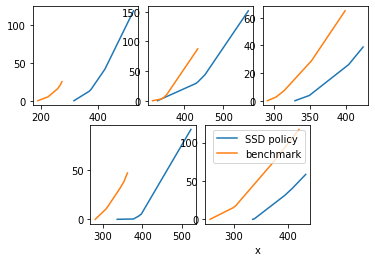

In [295]:
x_1_eval,x_2_eval = x_1,x_2
x_1_bcm, x_2_bcm = x_1_dummy,x_2_dummy

import matplotlib.pyplot as plt
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
axs = [ax1,ax2,ax3,ax4,ax5]
w_eval = F2_policy_stage_3(x_1_eval, x_2_eval,scenario)
w_bcm = F2_policy_stage_3(x_1_bcm, x_2_bcm, scenario)
plt.xlabel('x')
for i in range(scenario['S_scenario']):
    sort_keys = sorted(w_eval[i].keys())
    sort_keys_bcm = sorted(w_bcm[i].keys())
    axs[i].plot(sort_keys,[w_eval[i][_] for _ in sort_keys], label='SSD policy')
    axs[i].plot(sort_keys_bcm,[w_bcm[i][_] for _ in sort_keys_bcm], label='benchmark')

plt.legend()
plt.show()

In [307]:
feasibility_check(x_1,x_2,scenario)

True

In [294]:
eval_rst = evaluation_policy(x_12,x_22, scenario)
expected = eval_rst['stage_1']['z_1'] + eval_rst['stage_1']['expected_reward']
print(expected)

399.55104903851577


In [160]:
x_1_eval,x_2_eval = x_1,x_2
x_1_bcm, x_2_bcm = x_1_dummy,x_2_dumm

import matplotlib.pyplot as plt
fig = plt.gcf()
fig.set_size_inches(15, 12)
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
axs = [ax1,ax2,ax3,ax4,ax5]
w_eval = F2_policy_stage_3(x_1_eval,x_2_eval,scenario)
w_bcm = F2_policy_stage_3(x_1_bcm, x_2_bcm, scenario)
plt.xlabel('x') 
for i in range(scenario['S_scenario']):
    sort_keys = sorted(w_eval[i].keys())
    sort_keys_bcm = sorted(w_bcm[i].keys())
    end = max(sort_keys[-1],sort_keys_bcm[-1])
    w_bcm[i][end] = (end-sort_keys_bcm[-1])+w_bcm[i][sort_keys_bcm[-1]]

    sort_keys_bcm.append(end)
    axs[i].plot(sort_keys,[w_eval[i][_] for _ in sort_keys], label='SSD policy', linewidth=4)
    axs[i].plot(sort_keys_bcm,[w_bcm[i][_] for _ in sort_keys_bcm], label='benchmark', linewidth=4)
plt.legend()
plt.show()

NameError: name 'x_2_dumm' is not defined

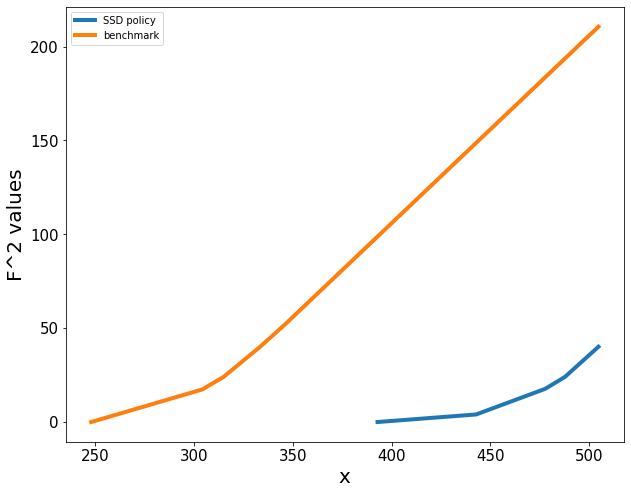

In [259]:
x_1_eval,x_2_eval = x_12,x_22
x_1_bcm, x_2_bcm = x_1_dummy,x_2_dummy

fig = plt.gcf()
fig.set_size_inches(10, 8)

u_eval = F2_policy_stage_2(x_1_eval,x_2_eval,scenario)
u_bcm = F2_policy_stage_2(x_1_bcm, x_2_bcm, scenario)
sort_keys = sorted(u_eval.keys())
sort_keys_bcm = sorted(u_bcm.keys())
end = max(sort_keys[-1],sort_keys_bcm[-1])
u_bcm[end] = (end-sort_keys_bcm[-1])+u_bcm[sort_keys_bcm[-1]]
sort_keys_bcm.append(end)
plt.plot(sort_keys,[u_eval[_] for _ in sort_keys], label='SSD policy',linewidth=4)
plt.plot(sort_keys_bcm,[u_bcm[_] for _ in sort_keys_bcm], label='benchmark',linewidth=4)
plt.xlabel('x',size = 20)
plt.ylabel('F^2 values', size = 20)
plt.legend()
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

In [163]:
x_2_bcm

[[2, 4, 9, 2.5, 3, 1, 3, 8, 3, 2],
 [8, 8, 4, 5, 5, 6, 2, 6.0, 1, 2],
 [1.25, 7, 7, 8, 3.5, 3, 7, 8.0, 7, 3],
 [8, 1, 5, 7, 7, 9, 7, 7, 5, 5],
 [7, 5, 6, 5, 7, 8, 4, 8.0, 9, 7]]

{0: {203.25: 35.965979226197135, 262.25: 80.04695752361079, 170.25: 17.823554535606853, 173.25: 18.994331737654484, 95.25: 0.0}, 1: {37.75: 0.0, 158.75: 41.84142353513229, 126.75: 23.03430473800074, 116.75: 18.869347314812387, 156.75: 40.07785537841611}, 2: {122.75: 0.0, 134.75: 3.278849485893404, 181.75: 33.726043823967885, 224.75: 66.80150141779804, 130.75: 1.7420159716339174}, 3: {139.5: 26.55880878587824, 149.5: 34.24781087334598, 137.5: 25.09138717060865, 56.5: 0.0, 113.5: 13.440423495053913}, 4: {142.0: 19.685479349224885, 182.0: 34.917453825531666, 191.0: 41.99321074888972, 151.0: 22.797562669090613, 10.0: 0.0}}
{0: {133.57142857142856: 15.82345782594965, 96.57142857142856: 3.68471282764643, 75.57142857142856: 0.0, 171.57142857142856: 37.8991384489603}, 1: {87.57142857142858: 0.0, 191.57142857142858: 33.614238278706445, 180.57142857142858: 27.364936377220808, 151.57142857142858: 15.28655984997459, 205.57142857142858: 43.222918147220305}, 2: {158.57142857142856: 4.827235081208326

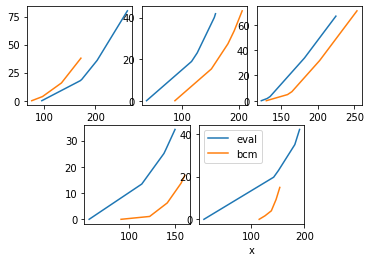

In [69]:
import matplotlib.pyplot as plt
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
axs = [ax1,ax2,ax3,ax4,ax5]
w_eval = F2_policy_stage_3(x_1,x_2,scenario)
print(w_eval)
w_bcm = F2_policy_stage_3(x_1_dummy, x_2_dummy, scenario)
print(w_bcm)
plt.xlabel('x')
for i in range(scenario['S_scenario']):
    sort_keys = sorted(w_eval[i].keys())
    sort_keys_bcm = sorted(w_bcm[i].keys())
    axs[i].plot(sort_keys,[w_eval[i][_] for _ in sort_keys], label='eval')
    axs[i].plot(sort_keys_bcm,[w_bcm[i][_] for _ in sort_keys_bcm], label='bcm')

plt.legend()
plt.show()

### Policy evaluation F function

In [68]:
import matplotlib.pyplot as plt

def F2_policy_stage_3(x_1, x_2, scenario):
    n_item = scenario['n_item']
    S_scenario = scenario['S_scenario']
    L_scenario = scenario['L_scenario']
    
    evaluation = evaluation_policy(x_1, x_2, scenario)
    
    y_3_eval = {}
    for s in range(S_scenario):
        y_3_eval[s] = {(evaluation['stage_1']['z_1']+ \
                        evaluation['stage_2'][s]['z_2']+ \
                        evaluation['stage_3'][s][l]['z_3']):evaluation['stage_3'][s][l]['prob']\
                for l in range(L_scenario)}

    w_eval = {}
    for s in range(S_scenario):
        w_eval[s] = {}
        for y_3_j in y_3_eval[s].keys():
            w_eval[s][y_3_j] = sum(max(y_3_j-y_3_i,0)*prob for y_3_i,prob in y_3_eval[s].items())
    return w_eval

# def F2_bcm_stage_3( benchmark, scenario):
#     n_item = scenario['n_item']
#     S_scenario = scenario['S_scenario']
#     L_scenario = scenario['L_scenario']
    
#     y_1_bcm = benchmark['stage_1']['r'][0]
    
#     y_3_bcm = {}
#     for s in range(S_scenario):
#         y_3_bcm[s] = {benchmark['stage_3']['r'][s][l]:benchmark['stage_3']['s'][s][l]\
#                 for l in range(L_scenario)}
        
#     w_bcm = {}
#     for s in range(S_scenario):
#         w_bcm[s] = {}
#         for y_3_j in y_3_bcm[s].keys():
#             w_bcm[s][y_3_j] = sum(max(y_3_j-y_3_i,0)*prob for y_3_i,prob in y_3_bcm[s].items())
#     return w_bcm

In [99]:
def F2_policy_stage_2 (x_1, x_2, scenario):
    n_item = scenario['n_item']
    S_scenario = scenario['S_scenario']
    L_scenario = scenario['L_scenario']
    
    evaluation = evaluation_policy(x_1, x_2, scenario)

    theta = {}
    for s in range(S_scenario):
        theta[s] = evaluation['stage_1']['z_1'] + evaluation['stage_2'][s]['z_2']\
            + evaluation['stage_2'][s]['expected_reward']
    u = {}
    for s in range(S_scenario):
        u[theta[s]] =  sum( max(theta[s] -  theta[s_], 0)*evaluation['stage_2'][s_]['prob']\
                           for s_ in range(S_scenario))
        
    return u

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 6 rows, 21 columns and 61 nonzeros
Model fingerprint: 0xd646ba44
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [2e-02, 1e+00]
  Bounds range     [1e+01, 1e+03]
  RHS range        [4e+02, 6e+02]
Presolve removed 6 rows and 21 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.7619323e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.761932309e+02
0 x_1:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] z_1:  0.0
[]
[]
[]
[]
[]
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_S

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 36 rows, 21 columns and 391 nonzeros
Coefficient statistics:
  Matrix range     [6e-02, 1e+01]
  Objective range  [2e-02, 1e+00]
  Bounds range     [1e+01, 1e+03]
  RHS range        [5e+00, 6e+02]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.7619323e+02   1.001467e+02   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Infeasible model
6 x_1:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] z_1:  0.0
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gur

  Objective range  [2e-02, 1e+00]
  Bounds range     [1e+01, 1e+03]
  RHS range        [5e+00, 6e+02]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.7619323e+02   2.002934e+02   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Infeasible model
12 x_1:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] z_1:  0.0
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_sta

       0    4.7619323e+02   3.004401e+02   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Infeasible model
18 x_1:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] z_1:  0.0
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 8 physica

<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 131 rows, 21 columns and 1436 nonzeros
Coefficient statistics:
  Matrix range     [6e-02, 1e+01]
  Objective range  [2e-02, 1e+00]
  

<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 161 rows, 21 columns and 1766 nonzeros
Coefficient statistics:
  Matrix range     [6e-02, 1e+01]
  Objective range  [2e-02, 1e+00]
  Bounds range     [1e+01, 1e+03]
  RHS range        [5e+00, 6e+02]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.7619323e+02   5.174247e+02   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Infeasible model
31 x_1:  [0.0,

<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 191 rows, 21 columns and 2096 nonzeros
Coefficient statistics:
  Matrix range     [6e-02, 1e+01]
  Objective range  [2e-02, 1e+00]
  Bounds range     [1e+01, 1e+03]
  RHS range        [5e+00, 6e+02]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.7619323e+02   6.175714e+02   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Infeasible model
37 x_1:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] z_1:  0.0
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 221 rows, 21 columns and 2426 nonzeros
Coefficient statistics:
  Matrix range     [6e-02, 1e+01]
  Objective range  [2e-02, 1e+00]
  Bounds range     [1e+01, 1e+03]
  RHS range        [5e+00, 6e+02]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.7619323e+02   7.177181e+02   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Infeasible model
43 x_1:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] z_1:  0.0
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<

  Matrix range     [6e-02, 1e+01]
  Objective range  [2e-02, 1e+00]
  Bounds range     [1e+01, 1e+03]
  RHS range        [5e+00, 6e+02]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.7619323e+02   8.178648e+02   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Infeasible model
49 x_1:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] z_1:  0.0
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuo

       0    4.7619323e+02   9.180115e+02   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Infeasible model
55 x_1:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] z_1:  0.0
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 8 physica

<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 316 rows, 21 columns and 3471 nonzeros
Coefficient statistics:
  Matrix range     [6e-02, 1e+01]
  Objective range  [2e-02, 1e+00]
  

<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 376 rows, 21 columns and 4131 nonzeros
Coefficient statistics:
  Matrix range     [6e-02, 1e+01]
  Objective range  [2e-02, 1e+00]
  Bounds range     [1e+01, 1e+03]
  RHS range        [5e+00, 6e+02]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.7619323e+02   1.235143e+03   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Infeasible model
74 x_1:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] z_1:  0.0
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 406 rows, 21 columns and 4461 nonzeros
Coefficient statistics:
  Matrix range     [6e-02, 1e+01]
  Objective range  [2e-02, 1e+00]
  Bounds range     [1e+01, 1e+03]
  RHS range        [5e+00, 6e+02]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.7619323e+02   1.335290e+03   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Infeasible model
80 x_1:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] z_1:  0.0
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs

Coefficient statistics:
  Matrix range     [6e-02, 1e+01]
  Objective range  [2e-02, 1e+00]
  Bounds range     [1e+01, 1e+03]
  RHS range        [5e+00, 6e+02]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.7619323e+02   1.435436e+03   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Infeasible model
86 x_1:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] z_1:  0.0
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.7619323e+02   1.535583e+03   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Infeasible model
92 x_1:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] z_1:  0.0
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
Gurobi Optimizer

Infeasible model
98 x_1:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] z_1:  0.0
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 501 rows, 21 columns and 5506 nonzeros
Coeffic

 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.07692307692307693 z_1> <= -7
fs_cut_8_1: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.060026215526260945 z_1> <= -5.2096
fs_cut_8_2: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.057692307692307696 z_1> <= -7.43794
fs_cut_8_3: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.057299437159112294 z_1> <= -5.81162
fs_cut_8_4: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.07692307692307693 z_1> <= -7.92308
fs_cut_9_0: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.07692307692307693 z_1> <= -7
fs_cut_9_1: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.060026215526260945 z_1

 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.057692307692307696 z_1> <= -7.43794
fs_cut_18_3: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.057299437159112294 z_1> <= -5.81162
fs_cut_18_4: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.07692307692307693 z_1> <= -7.92308
fs_cut_19_0: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.07692307692307693 z_1> <= -7
fs_cut_19_1: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.060026215526260945 z_1> <= -5.2096
fs_cut_19_2: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.057692307692307696 z_1> <= -7.43794
fs_cut_19_3: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.057299437

 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.07692307692307693 z_1> <= -7.92308
fs_cut_29_0: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.07692307692307693 z_1> <= -7
fs_cut_29_1: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.060026215526260945 z_1> <= -5.2096
fs_cut_29_2: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.057692307692307696 z_1> <= -7.43794
fs_cut_29_3: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.057299437159112294 z_1> <= -5.81162
fs_cut_29_4: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.07692307692307693 z_1> <= -7.92308
fs_cut_30_0: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.0769230769

 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.060026215526260945 z_1> <= -5.2096
fs_cut_39_2: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.057692307692307696 z_1> <= -7.43794
fs_cut_39_3: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.057299437159112294 z_1> <= -5.81162
fs_cut_39_4: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.07692307692307693 z_1> <= -7.92308
fs_cut_40_0: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.07692307692307693 z_1> <= -7
fs_cut_40_1: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.060026215526260945 z_1> <= -5.2096
fs_cut_40_2: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.0576923076

 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.057299437159112294 z_1> <= -5.81162
fs_cut_49_4: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.07692307692307693 z_1> <= -7.92308
fs_cut_50_0: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.07692307692307693 z_1> <= -7
fs_cut_50_1: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.060026215526260945 z_1> <= -5.2096
fs_cut_50_2: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.057692307692307696 z_1> <= -7.43794
fs_cut_50_3: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.057299437159112294 z_1> <= -5.81162
fs_cut_50_4: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.076923076

 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.07692307692307693 z_1> <= -7
fs_cut_60_1: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.060026215526260945 z_1> <= -5.2096
fs_cut_60_2: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.057692307692307696 z_1> <= -7.43794
fs_cut_60_3: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.057299437159112294 z_1> <= -5.81162
fs_cut_60_4: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.07692307692307693 z_1> <= -7.92308
fs_cut_61_0: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.07692307692307693 z_1> <= -7
fs_cut_61_1: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.0600262155262609

 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.057692307692307696 z_1> <= -7.43794
fs_cut_70_3: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.057299437159112294 z_1> <= -5.81162
fs_cut_70_4: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.07692307692307693 z_1> <= -7.92308
fs_cut_71_0: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.07692307692307693 z_1> <= -7
fs_cut_71_1: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.060026215526260945 z_1> <= -5.2096
fs_cut_71_2: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.057692307692307696 z_1> <= -7.43794
fs_cut_71_3: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.057299437

 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.07692307692307693 z_1> <= -7.92308
fs_cut_81_0: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.07692307692307693 z_1> <= -7
fs_cut_81_1: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.060026215526260945 z_1> <= -5.2096
fs_cut_81_2: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.057692307692307696 z_1> <= -7.43794
fs_cut_81_3: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.057299437159112294 z_1> <= -5.81162
fs_cut_81_4: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.07692307692307693 z_1> <= -7.92308
fs_cut_82_0: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.0769230769

 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.060026215526260945 z_1> <= -5.2096
fs_cut_91_2: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.057692307692307696 z_1> <= -7.43794
fs_cut_91_3: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.057299437159112294 z_1> <= -5.81162
fs_cut_91_4: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.07692307692307693 z_1> <= -7.92308
fs_cut_92_0: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.07692307692307693 z_1> <= -7
fs_cut_92_1: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.060026215526260945 z_1> <= -5.2096
fs_cut_92_2: <gurobi.LinExpr: x_1[0] + x_1[1] + x_1[2] + x_1[3] + x_1[4] + x_1[5] +
 x_1[6] + x_1[7] + x_1[8] + x_1[9] + -0.0576923076

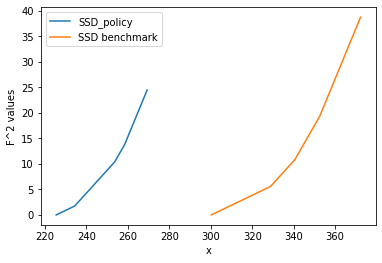

In [124]:
opt_ssd_benchmark = ssd_benchmark_from_table( x_1_opt, x_2_opt, scenario)
x_1,x_2 = three_stage_multi_item_SSD_newsvendor(x_1_0 = x_1_0, z_1_0 =z_1_0, scenario=scenario, \
                                benchmark = opt_ssd_benchmark , max_itr = 100,\
                                policy_return =  True)
u_eval = F2_policy_stage_2(x_1,x_2,scenario)
u_bcm = F2_policy_stage_2(x_1_opt, x_2_opt, scenario)

sort_keys = sorted(u_eval.keys())
sort_keys_bcm = sorted(u_bcm.keys())
plt.plot(sort_keys,[u_eval[_] for _ in sort_keys], label='SSD_policy')
plt.plot(sort_keys_bcm,[u_bcm[_] for _ in sort_keys_bcm], label='SSD benchmark')
plt.xlabel('x')
plt.ylabel('F^2 values')
plt.legend()
plt.show()

In [111]:
bcm_rst = evaluation_policy(x_1_opt, x_2_opt, scenario)
opt_ssd_benchmark = ssd_benchmark_from_evaluation(bcm_rst, scenario)
x_1,x_2 = three_stage_multi_item_SSD_newsvendor(x_1_0 = x_1_0, z_1_0 =z_1_0, scenario=scenario, \
                                benchmark = opt_ssd_benchmark , max_itr = 100,\
                                policy_return =  True)
eval_rst = evaluation_policy(x_1,x_2,scenario)

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 6 rows, 21 columns and 61 nonzeros
Model fingerprint: 0xad846557
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [2e-02, 1e+00]
  Bounds range     [1e+01, 1e+03]
  RHS range        [3e+02, 3e+02]
Presolve removed 1 rows and 8 columns
Presolve time: 0.00s
Presolved: 5 rows, 13 columns, 40 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.9439864e+02   5.079302e+01   0.000000e+00      0s
       6    5.8785729e+02   0.000000e+00   0.000000e+00      0s

Solved in 6 iterations and 0.01 seconds (0.00 work units)
Optimal objective  5.878572906e+02
0 x_1:  [0.0, 4.596630773429998, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 2.0358888336411796] z_1:  -394.673634
[]
[]
[]
[]
[]
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Para

Coefficient statistics:
  Matrix range     [8e-02, 1e+01]
  Objective range  [2e-02, 1e+00]
  Bounds range     [1e+01, 1e+03]
  RHS range        [1e+01, 7e+02]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.1320592e+02   3.008209e+01   0.000000e+00      0s
       7    5.1006172e+02   0.000000e+00   0.000000e+00      0s

Solved in 7 iterations and 0.01 seconds (0.00 work units)
Optimal objective  5.100617242e+02
6 x_1:  [2.553075458141639, 7.00000000000001, 10.0, 10.0, 9.454545454545434, 10.0, 0.0, 8.689883198642727, 10.0, 0.0] z_1:  -325.981059
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> st

       0    4.7686305e+02   1.841869e+01   0.000000e+00      0s
       8    4.6638773e+02   0.000000e+00   0.000000e+00      0s

Solved in 8 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.663877257e+02
13 x_1:  [5.701225382058557, 1.1255891259896913, 4.208922459323021, 7.166588116534716, 6.500471300791756, 10.0, 10.0, 3.499528699208244, 10.0, 1.0449832446627894] z_1:  -291.475874
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
<gurobi.Model Continuous instance reward_problem_two_stage_multi_item_SSD: 128 constrs, 72 vars, Parameter changes: LogToConsole=0> status: 3
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 76 rows, 21 co

       0    4.3435139e+02   5.425903e+00   0.000000e+00      0s
       6    4.3318891e+02   0.000000e+00   0.000000e+00      0s

Solved in 6 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.331889125e+02
21 x_1:  [5.314940040170804, 5.99999999999999, 6.999999999999996, 5.9999999999999964, 2.0000000000000013, 10.0, 6.923076923076932, 7.999999999999998, 5.000000000000019, 3.0000000000000155] z_1:  -312.981059
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 116 rows, 21 columns and 611 nonzeros
Coefficient statistics:
  Matrix range     [8e-02, 1e+01]
  Objective range  [2e-02, 1e+00]
  Bounds range     [1e+01, 1e+03]
  RHS range        [4e-01, 7e+02]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.3318891e+02   7.500000e-01   0.000000e+00      0s
       3    4.3284287e+02   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations 

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 166 rows, 21 columns and 921 nonzeros
Coefficient statistics:
  Matrix range     [8e-02, 1e+01]
  Objective range  [2e-02, 1e+00]
  Bounds range     [1e+01, 1e+03]
  RHS range        [4e-01, 7e+02]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.3284287e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.328428685e+02
32 x_1:  [7.1226323478631635, 5.999999999999981, 5.999999999999967, 6.0, 2.0000000000000036, 10.0, 5.999999999999982, 7.9999999999999964, 5.000000000000012, 3.0000000000000155] z_1:  -312.981059
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 171 rows, 21 columns and 952 nonzeros
Coefficient statistics:
  Matrix 


Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.328428685e+02
42 x_1:  [7.1226323478631635, 5.999999999999981, 5.999999999999967, 6.0, 2.0000000000000036, 10.0, 5.999999999999982, 7.9999999999999964, 5.000000000000012, 3.0000000000000155] z_1:  -312.981059
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 221 rows, 21 columns and 1262 nonzeros
Coefficient statistics:
  Matrix range     [8e-02, 1e+01]
  Objective range  [2e-02, 1e+00]
  Bounds range     [1e+01, 1e+03]
  RHS range        [4e-01, 7e+02]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.3284287e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.328428685e+02
43 x_1:  [7.1226323478631635, 5.999999999999981, 5.999999999999967, 6.0, 2.0000000000000036, 10.0, 5.999999999999982, 7.9999999999999

Coefficient statistics:
  Matrix range     [8e-02, 1e+01]
  Objective range  [2e-02, 1e+00]
  Bounds range     [1e+01, 1e+03]
  RHS range        [4e-01, 7e+02]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.3284287e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.328428685e+02
53 x_1:  [7.1226323478631635, 5.999999999999981, 5.999999999999967, 6.0, 2.0000000000000036, 10.0, 5.999999999999982, 7.9999999999999964, 5.000000000000012, 3.0000000000000155] z_1:  -312.981059
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 276 rows, 21 columns and 1603 nonzeros
Coefficient statistics:
  Matrix range     [8e-02, 1e+01]
  Objective range  [2e-02, 1e+00]
  Bounds range     [1e+01, 1e+03]
  RHS range        [4e-01, 7e+02]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
   

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 326 rows, 21 columns and 1913 nonzeros
Coefficient statistics:
  Matrix range     [8e-02, 1e+01]
  Objective range  [2e-02, 1e+00]
  Bounds range     [1e+01, 1e+03]
  RHS range        [4e-01, 7e+02]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.3284287e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.328428685e+02
64 x_1:  [7.1226323478631635, 5.999999999999981, 5.999999999999967, 6.0, 2.0000000000000036, 10.0, 5.999999999999982, 7.9999999999999964, 5.000000000000012, 3.0000000000000155] z_1:  -312.981059
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 331 rows, 21 columns and 1944 nonzeros
Coefficient statistics:
  Matri


Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.328428685e+02
74 x_1:  [7.1226323478631635, 5.999999999999981, 5.999999999999967, 6.0, 2.0000000000000036, 10.0, 5.999999999999982, 7.9999999999999964, 5.000000000000012, 3.0000000000000155] z_1:  -312.981059
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 381 rows, 21 columns and 2254 nonzeros
Coefficient statistics:
  Matrix range     [8e-02, 1e+01]
  Objective range  [2e-02, 1e+00]
  Bounds range     [1e+01, 1e+03]
  RHS range        [4e-01, 7e+02]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.3284287e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.328428685e+02
75 x_1:  [7.1226323478631635, 5.999999999999981, 5.999999999999967, 6.0, 2.0000000000000036, 10.0, 5.999999999999982, 7.9999999999999

Coefficient statistics:
  Matrix range     [8e-02, 1e+01]
  Objective range  [2e-02, 1e+00]
  Bounds range     [1e+01, 1e+03]
  RHS range        [4e-01, 7e+02]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.3284287e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.328428685e+02
85 x_1:  [7.1226323478631635, 5.999999999999981, 5.999999999999967, 6.0, 2.0000000000000036, 10.0, 5.999999999999982, 7.9999999999999964, 5.000000000000012, 3.0000000000000155] z_1:  -312.981059
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 436 rows, 21 columns and 2595 nonzeros
Coefficient statistics:
  Matrix range     [8e-02, 1e+01]
  Objective range  [2e-02, 1e+00]
  Bounds range     [1e+01, 1e+03]
  RHS range        [4e-01, 7e+02]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
   

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 486 rows, 21 columns and 2905 nonzeros
Coefficient statistics:
  Matrix range     [8e-02, 1e+01]
  Objective range  [2e-02, 1e+00]
  Bounds range     [1e+01, 1e+03]
  RHS range        [4e-01, 7e+02]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.3284287e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.328428685e+02
96 x_1:  [7.1226323478631635, 5.999999999999981, 5.999999999999967, 6.0, 2.0000000000000036, 10.0, 5.999999999999982, 7.9999999999999964, 5.000000000000012, 3.0000000000000155] z_1:  -312.981059
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 491 rows, 21 columns and 2936 nonzeros
Coefficient statistics:
  Matri

 -0.09090909090909091 z_1> <= 18.7256
obj_cut_7_4: <gurobi.LinExpr: -10.0 x_1[0] + -12.0 x_1[1] + -13.0 x_1[6] + -11.0 x_1[9]
 + v_s=4> <= 621.279
fs_cut_8_0: <gurobi.LinExpr: -0.9230769230769231 x_1[1] + -1.0 x_1[6] +
 -0.23076923076923078 x_1[8] + -1.0 x_1[9] + -0.07692307692307693 z_1> <= 15.2654
obj_cut_8_1: <gurobi.LinExpr: -12.0 x_1[2] + -13.0 x_1[6] + -13.0 x_1[7] + -11.0 x_1[9]
 + v_s=1> <= 480.359
obj_cut_8_2: <gurobi.LinExpr: -12.0 x_1[1] + -13.0 x_1[6] + -3.0 x_1[8] + -11.0 x_1[9]
 + v_s=2> <= 605.446
fs_cut_8_3: <gurobi.LinExpr: -1.0 x_1[6] + -1.0 x_1[7] + -0.2727272727272727 x_1[8] +
 -1.0 x_1[9] + -0.09090909090909091 z_1> <= 12.0892
obj_cut_8_4: <gurobi.LinExpr: -12.0 x_1[1] + -11.0 x_1[4] + -13.0 x_1[6] + -3.0 x_1[8]
 + -11.0 x_1[9] + v_s=4> <= 555.279
fs_cut_9_0: <gurobi.LinExpr: -0.9090909090909092 x_1[0] + -1.0 x_1[9] +
 -0.09090909090909091 z_1> <= 25.7682
obj_cut_9_1: <gurobi.LinExpr: -10.0 x_1[0] + -12.0 x_1[2] + -12.0 x_1[3] + -11.0 x_1[9]
 + v_s=1> <= 447.359
ob

 x_1[4] + -13.0 x_1[7] + -11.0 x_1[9] + v_s=1> <= 321.359
obj_cut_21_2: <gurobi.LinExpr: -10.0 x_1[0] + -12.0 x_1[1] + -12.0 x_1[2] + -11.0
 x_1[4] + -13.0 x_1[6] + -3.0 x_1[8] + v_s=2> <= 441.446
fs_cut_21_3: <gurobi.LinExpr: -0.8461538461538463 x_1[4] + -1.0 x_1[7] +
-0.23076923076923078 x_1[8] + -0.8461538461538463 x_1[9] + -0.07692307692307693 z_1> <=
 10.6909
obj_cut_21_4: <gurobi.LinExpr: -12.0 x_1[1] + -11.0 x_1[4] + -13.0 x_1[6] + -3.0 x_1[8]
 + v_s=4> <= 577.279
obj_cut_22_0: <gurobi.LinExpr: -10.0 x_1[0] + -12.0 x_1[1] + -11.0 x_1[4] + -3.0 x_1[8]
 + -11.0 x_1[9] + v_s=0> <= 481.32
obj_cut_22_1: <gurobi.LinExpr: -10.0 x_1[0] + -12.0 x_1[2] + -12.0 x_1[3] + -11.0
 x_1[4] + -13.0 x_1[7] + -11.0 x_1[9] + v_s=1> <= 321.359
obj_cut_22_2: <gurobi.LinExpr: -10.0 x_1[0] + -12.0 x_1[1] + -12.0 x_1[2] + -12.0
 x_1[3] + -11.0 x_1[4] + -13.0 x_1[6] + -3.0 x_1[8] + v_s=2> <= 369.446
  fs_cut_22_3: <gurobi.LinExpr: -1.0 x_1[9] + -0.09090909090909091 z_1> <= 25.4528
obj_cut_22_4: <gurobi.Li

 x_1[6] + -3.0 x_1[8] + v_s=4> <= 505.279
obj_cut_34_0: <gurobi.LinExpr: -10.0 x_1[0] + -12.0 x_1[1] + -12.0 x_1[2] + -11.0
 x_1[4] + -13.0 x_1[6] + -3.0 x_1[8] + -11.0 x_1[9] + v_s=0> <= 331.32
obj_cut_34_1: <gurobi.LinExpr: -10.0 x_1[0] + -12.0 x_1[2] + -12.0 x_1[3] + -11.0
 x_1[4] + -13.0 x_1[7] + -11.0 x_1[9] + v_s=1> <= 321.359
obj_cut_34_2: <gurobi.LinExpr: -10.0 x_1[0] + -12.0 x_1[1] + -12.0 x_1[2] + -12.0
 x_1[3] + -11.0 x_1[4] + -13.0 x_1[6] + -3.0 x_1[8] + v_s=2> <= 369.446
  fs_cut_34_3: <gurobi.LinExpr: -1.0 x_1[9] + -0.09090909090909091 z_1> <= 25.4528
obj_cut_34_4: <gurobi.LinExpr: -12.0 x_1[1] + -12.0 x_1[2] + -11.0 x_1[4] + -13.0
 x_1[6] + -3.0 x_1[8] + v_s=4> <= 505.279
obj_cut_35_0: <gurobi.LinExpr: -10.0 x_1[0] + -12.0 x_1[1] + -12.0 x_1[2] + -11.0
 x_1[4] + -13.0 x_1[6] + -3.0 x_1[8] + -11.0 x_1[9] + v_s=0> <= 331.32
obj_cut_35_1: <gurobi.LinExpr: -10.0 x_1[0] + -12.0 x_1[2] + -12.0 x_1[3] + -11.0
 x_1[4] + -13.0 x_1[7] + -11.0 x_1[9] + v_s=1> <= 321.359
obj_cut_35_

 x_1[3] + -11.0 x_1[4] + -13.0 x_1[6] + -3.0 x_1[8] + v_s=2> <= 369.446
  fs_cut_46_3: <gurobi.LinExpr: -1.0 x_1[9] + -0.09090909090909091 z_1> <= 25.4528
obj_cut_46_4: <gurobi.LinExpr: -12.0 x_1[1] + -12.0 x_1[2] + -11.0 x_1[4] + -13.0
 x_1[6] + -3.0 x_1[8] + v_s=4> <= 505.279
obj_cut_47_0: <gurobi.LinExpr: -10.0 x_1[0] + -12.0 x_1[1] + -12.0 x_1[2] + -11.0
 x_1[4] + -13.0 x_1[6] + -3.0 x_1[8] + -11.0 x_1[9] + v_s=0> <= 331.32
obj_cut_47_1: <gurobi.LinExpr: -10.0 x_1[0] + -12.0 x_1[2] + -12.0 x_1[3] + -11.0
 x_1[4] + -13.0 x_1[7] + -11.0 x_1[9] + v_s=1> <= 321.359
obj_cut_47_2: <gurobi.LinExpr: -10.0 x_1[0] + -12.0 x_1[1] + -12.0 x_1[2] + -12.0
 x_1[3] + -11.0 x_1[4] + -13.0 x_1[6] + -3.0 x_1[8] + v_s=2> <= 369.446
  fs_cut_47_3: <gurobi.LinExpr: -1.0 x_1[9] + -0.09090909090909091 z_1> <= 25.4528
obj_cut_47_4: <gurobi.LinExpr: -12.0 x_1[1] + -12.0 x_1[2] + -11.0 x_1[4] + -13.0
 x_1[6] + -3.0 x_1[8] + v_s=4> <= 505.279
obj_cut_48_0: <gurobi.LinExpr: -10.0 x_1[0] + -12.0 x_1[1] + -12.0 

 x_1[4] + -13.0 x_1[6] + -3.0 x_1[8] + -11.0 x_1[9] + v_s=0> <= 331.32
obj_cut_59_1: <gurobi.LinExpr: -10.0 x_1[0] + -12.0 x_1[2] + -12.0 x_1[3] + -11.0
 x_1[4] + -13.0 x_1[7] + -11.0 x_1[9] + v_s=1> <= 321.359
obj_cut_59_2: <gurobi.LinExpr: -10.0 x_1[0] + -12.0 x_1[1] + -12.0 x_1[2] + -12.0
 x_1[3] + -11.0 x_1[4] + -13.0 x_1[6] + -3.0 x_1[8] + v_s=2> <= 369.446
  fs_cut_59_3: <gurobi.LinExpr: -1.0 x_1[9] + -0.09090909090909091 z_1> <= 25.4528
obj_cut_59_4: <gurobi.LinExpr: -12.0 x_1[1] + -12.0 x_1[2] + -11.0 x_1[4] + -13.0
 x_1[6] + -3.0 x_1[8] + v_s=4> <= 505.279
obj_cut_60_0: <gurobi.LinExpr: -10.0 x_1[0] + -12.0 x_1[1] + -12.0 x_1[2] + -11.0
 x_1[4] + -13.0 x_1[6] + -3.0 x_1[8] + -11.0 x_1[9] + v_s=0> <= 331.32
obj_cut_60_1: <gurobi.LinExpr: -10.0 x_1[0] + -12.0 x_1[2] + -12.0 x_1[3] + -11.0
 x_1[4] + -13.0 x_1[7] + -11.0 x_1[9] + v_s=1> <= 321.359
obj_cut_60_2: <gurobi.LinExpr: -10.0 x_1[0] + -12.0 x_1[1] + -12.0 x_1[2] + -12.0
 x_1[3] + -11.0 x_1[4] + -13.0 x_1[6] + -3.0 x_1[8] +

  fs_cut_71_3: <gurobi.LinExpr: -1.0 x_1[9] + -0.09090909090909091 z_1> <= 25.4528
obj_cut_71_4: <gurobi.LinExpr: -12.0 x_1[1] + -12.0 x_1[2] + -11.0 x_1[4] + -13.0
 x_1[6] + -3.0 x_1[8] + v_s=4> <= 505.279
obj_cut_72_0: <gurobi.LinExpr: -10.0 x_1[0] + -12.0 x_1[1] + -12.0 x_1[2] + -11.0
 x_1[4] + -13.0 x_1[6] + -3.0 x_1[8] + -11.0 x_1[9] + v_s=0> <= 331.32
obj_cut_72_1: <gurobi.LinExpr: -10.0 x_1[0] + -12.0 x_1[2] + -12.0 x_1[3] + -11.0
 x_1[4] + -13.0 x_1[7] + -11.0 x_1[9] + v_s=1> <= 321.359
obj_cut_72_2: <gurobi.LinExpr: -10.0 x_1[0] + -12.0 x_1[1] + -12.0 x_1[2] + -12.0
 x_1[3] + -11.0 x_1[4] + -13.0 x_1[6] + -3.0 x_1[8] + v_s=2> <= 369.446
  fs_cut_72_3: <gurobi.LinExpr: -1.0 x_1[9] + -0.09090909090909091 z_1> <= 25.4528
obj_cut_72_4: <gurobi.LinExpr: -12.0 x_1[1] + -12.0 x_1[2] + -11.0 x_1[4] + -13.0
 x_1[6] + -3.0 x_1[8] + v_s=4> <= 505.279
obj_cut_73_0: <gurobi.LinExpr: -10.0 x_1[0] + -12.0 x_1[1] + -12.0 x_1[2] + -11.0
 x_1[4] + -13.0 x_1[6] + -3.0 x_1[8] + -11.0 x_1[9] + v_s

obj_cut_84_1: <gurobi.LinExpr: -10.0 x_1[0] + -12.0 x_1[2] + -12.0 x_1[3] + -11.0
 x_1[4] + -13.0 x_1[7] + -11.0 x_1[9] + v_s=1> <= 321.359
obj_cut_84_2: <gurobi.LinExpr: -10.0 x_1[0] + -12.0 x_1[1] + -12.0 x_1[2] + -12.0
 x_1[3] + -11.0 x_1[4] + -13.0 x_1[6] + -3.0 x_1[8] + v_s=2> <= 369.446
  fs_cut_84_3: <gurobi.LinExpr: -1.0 x_1[9] + -0.09090909090909091 z_1> <= 25.4528
obj_cut_84_4: <gurobi.LinExpr: -12.0 x_1[1] + -12.0 x_1[2] + -11.0 x_1[4] + -13.0
 x_1[6] + -3.0 x_1[8] + v_s=4> <= 505.279
obj_cut_85_0: <gurobi.LinExpr: -10.0 x_1[0] + -12.0 x_1[1] + -12.0 x_1[2] + -11.0
 x_1[4] + -13.0 x_1[6] + -3.0 x_1[8] + -11.0 x_1[9] + v_s=0> <= 331.32
obj_cut_85_1: <gurobi.LinExpr: -10.0 x_1[0] + -12.0 x_1[2] + -12.0 x_1[3] + -11.0
 x_1[4] + -13.0 x_1[7] + -11.0 x_1[9] + v_s=1> <= 321.359
obj_cut_85_2: <gurobi.LinExpr: -10.0 x_1[0] + -12.0 x_1[1] + -12.0 x_1[2] + -12.0
 x_1[3] + -11.0 x_1[4] + -13.0 x_1[6] + -3.0 x_1[8] + v_s=2> <= 369.446
  fs_cut_85_3: <gurobi.LinExpr: -1.0 x_1[9] + -0.090

obj_cut_96_4: <gurobi.LinExpr: -12.0 x_1[1] + -12.0 x_1[2] + -11.0 x_1[4] + -13.0
 x_1[6] + -3.0 x_1[8] + v_s=4> <= 505.279
obj_cut_97_0: <gurobi.LinExpr: -10.0 x_1[0] + -12.0 x_1[1] + -12.0 x_1[2] + -11.0
 x_1[4] + -13.0 x_1[6] + -3.0 x_1[8] + -11.0 x_1[9] + v_s=0> <= 331.32
obj_cut_97_1: <gurobi.LinExpr: -10.0 x_1[0] + -12.0 x_1[2] + -12.0 x_1[3] + -11.0
 x_1[4] + -13.0 x_1[7] + -11.0 x_1[9] + v_s=1> <= 321.359
obj_cut_97_2: <gurobi.LinExpr: -10.0 x_1[0] + -12.0 x_1[1] + -12.0 x_1[2] + -12.0
 x_1[3] + -11.0 x_1[4] + -13.0 x_1[6] + -3.0 x_1[8] + v_s=2> <= 369.446
  fs_cut_97_3: <gurobi.LinExpr: -1.0 x_1[9] + -0.09090909090909091 z_1> <= 25.4528
obj_cut_97_4: <gurobi.LinExpr: -12.0 x_1[1] + -12.0 x_1[2] + -11.0 x_1[4] + -13.0
 x_1[6] + -3.0 x_1[8] + v_s=4> <= 505.279
obj_cut_98_0: <gurobi.LinExpr: -10.0 x_1[0] + -12.0 x_1[1] + -12.0 x_1[2] + -11.0
 x_1[4] + -13.0 x_1[6] + -3.0 x_1[8] + -11.0 x_1[9] + v_s=0> <= 331.32
obj_cut_98_1: <gurobi.LinExpr: -10.0 x_1[0] + -12.0 x_1[2] + -12.0 x_

In [108]:
expected = [0,0] 
for s in range(S_scenario):
    expected[0] += eval_rst['stage_2'][s]['prob']*\
        sum(eval_rst['stage_3'][s][l]['current_tot_reward']*eval_rst['stage_3'][s][l]['prob']\
            for l in range(L_scenario))
    expected[1] += bcm_rst['stage_2'][s]['prob']*\
        sum(bcm_rst['stage_3'][s][l]['current_tot_reward']*bcm_rst['stage_3'][s][l]['prob']\
            for l in range(L_scenario))
print(expected)

[415.43160244708423, 333.52670713840246]


In [157]:
z_1 = -u_eval['stage_1']['cost']
z_2 = u_eval['stage_2'][0]['revenue']-u_eval['stage_2'][0]['cost']
z_3 = [ u_eval['stage_3'][0][i]['revenue']+z_1+z_1-y_1-y_2 for i in range(L_scenario)] 
z_3

-190.0 -50.0
-67.0 -90.0


[235.0, 510.0, 213.0, 269.0, 397.0]

In [137]:
y_1 = opt_ssd_benchmark['stage_1']['r'][0]
y_2 = opt_ssd_benchmark['stage_2']['r'][0]
y_3 = opt_ssd_benchmark['stage_3']['r'][0]
y_3

[440.6666666666667,
 623.4166666666666,
 334.4166666666667,
 385.75,
 522.4166666666667]

In [158]:
sigma = z_1+z_2-y_1-y_2
print(z_1,y_1)
print(z_2,y_2)
print(sigma)

-190.0 -50.0
-67.0 -90.0
-117.0


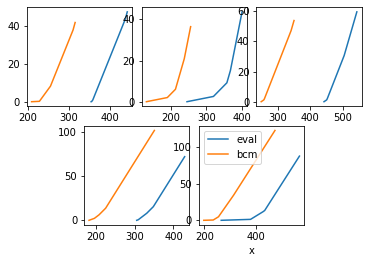

In [42]:
import matplotlib.pyplot as plt
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
axs = [ax1,ax2,ax3,ax4,ax5]
w_eval = F2_policy_stage_3(x_1,x_2,scenario)
w_bcm = F2_policy_stage_3(x_1_opt, x_2_opt, scenario)
plt.xlabel('x')
for i in range(scenario['S_scenario']):
    sort_keys = sorted(w_eval[i].keys())
    sort_keys_bcm = sorted(w_bcm[i].keys())
    axs[i].plot(sort_keys,[w_eval[i][_] for _ in sort_keys], label='eval')
    axs[i].plot(sort_keys_bcm,[w_bcm[i][_] for _ in sort_keys_bcm], label='bcm')

plt.legend()
plt.show()

In [ ]:
rst = [ profit_distribution(),
        profit_distribution(evaluation_policy(x_1_dummy_SSD,x_2_dummy_SSD,scenario)), 
      ]
print(f"{'(S,L)':<6}|| {'dummy':<8} || {'dummy_SSD':<10} || probability(S=s, L=l|S=s)")
for _ in rst[0].keys():
    print(f"{_}:  {rst[0][_]['val']:<8} || {rst[1][_]['val']:<10} || {rst[2][_]['val']:<8} || {rst[3][_]['val']:<8} ||{rst[0][_]['prob']}")


In [197]:
def profit_distribution(evaluation_rst):
    profit = {}
    profit_1 = evaluation_rst['stage_1']['current_tot_reward'] 
    profit_2 = {}
    profit_3 = {}
    for i,dict_2 in evaluation_rst['stage_2'].items():
        profit_2[i] = dict_2['current_tot_reward']
        for j,dict_3 in evaluation_rst['stage_3'][i].items():
            profit_3[(i,j)] = {'val':dict_3['current_tot_reward'] ,\
                               'prob':(dict_2['prob'], dict_3['prob'])}
    return profit_3

In [75]:
###### evaluation reagrding SSD 
print('Policy: SSD, SSD benchmark:dummy')
x_1_dummy = x_1_generator(scenario)
benchmark_dummy = ssd_benchmark_from(x_1_dummy, x_2_i, scenario)
x_1_0 = x_1_random
z_1_0 = 0
x_1_dummy_SSD,x_2_dummy_SSD = three_stage_multi_item_SSD_newsvendor(x_1_0 = x_1_0, z_1_0 =z_1_0, scenario=scenario, \
                                benchmark=benchmark_dummy, max_itr = 20,\
                                policy_return =  True)

Policy: SSD, SSD benchmark:dummy


KeyboardInterrupt: 

In [206]:
rst = [ profit_distribution(eval_rst),
        profit_distribution(bcm_rst), 

      ]
print(f"{'(S,L)':<6}|| {'policy w SSD constraints':<20} || {'risk neutral policy':<20} || probability(S=s, L=l|S=s)")
for _ in rst[0].keys():
    print(f"{_}:  {round2(rst[0][_]['val']):<24} || {round2(rst[1][_]['val']):<20} ||{rst[0][_]['prob']}")


(S,L) || policy w SSD constraints || risk neutral policy  || probability(S=s, L=l|S=s)
(0, 0):  436.0                    || 300.666667           ||(0.22387847895810087, 0.24572219870000458)
(0, 1):  575.0                    || 483.416667           ||(0.22387847895810087, 0.1820638474572161)
(0, 2):  310.0                    || 194.416667           ||(0.22387847895810087, 0.31427676226668344)
(0, 3):  348.0                    || 245.75               ||(0.22387847895810087, 0.0005177259599891837)
(0, 4):  516.0                    || 382.416667           ||(0.22387847895810087, 0.2574194656161067)
(1, 0):  459.0                    || 233.0                ||(0.05187186573805417, 0.07289725257720754)
(1, 1):  515.0                    || 312.125              ||(0.05187186573805417, 0.1315484050847104)
(1, 2):  412.0                    || 234.0                ||(0.05187186573805417, 0.2045035698173737)
(1, 3):  470.0                    || 277.0                ||(0.05187186573805417, 0.3252096

In [20]:
def ssd_benchmark_from_table( x_1, x_2, scenario):
    
    n_item = scenario['n_item']
    S_scenario = scenario['S_scenario']
    L_scenario = scenario['L_scenario']
    d_2 = scenario['stage_2']['rd_prob'][0][0]
    prob_of_d_2 =  scenario['stage_2']['rd_prob'][0][1]
    
    d_3 = {}
    for s in range(S_scenario):
        d_3[s] = {}
        for l in range(L_scenario):
            d_3[s][l] = scenario['stage_3']['rd_prob'][s][0][l]
    
    prob_of_d_3 = {}
    for s in range(S_scenario):
        prob_of_d_3[s] = {}
        for l in range(L_scenario):
            prob_of_d_3[s][l] = scenario['stage_3']['rd_prob'][s][1][l]
    
    c_1 = scenario['stage_1']['cf']['c_1']
    c_2 = scenario['stage_2']['cf']['c_2']
    p_2 = scenario['stage_2']['cf']['p_2']
    p_3 = scenario['stage_3']['cf']['p_3']
    
    
    benchmark = {}
    benchmark['stage_1'] = {
        'r': [-sum(x_1[i]*c_1[i] for i in range(n_item))],
        's': [1.0]
    }
    
    
    benchmark['stage_2'] = {
        'r': [sum(p_2[i]*min(d_2[s][i],x_1[i])-c_2[i]*x_2[s][i] for i in range(n_item))\
                          for s in range(S_scenario)],
        's': prob_of_d_2
    }
    
    benchmark['stage_3'] = { 
        'r': { 
                s:[sum(p_3[i]*min( d_3[s][l][i], x_2[s][i]) for i in range(n_item)) \
                   for l in range(L_scenario)] for s in range(S_scenario)
        },
        's': { 
                s:prob_of_d_3[s] for s in range(S_scenario)
        }
    }
    
    return benchmark